## Skorch GA network classification example

In [16]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.ga_nn import GAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt

In [17]:
from src.alien import alien

obj=alien()
X_train, y_train=obj.dataset(modify_feature=True)
X = X_train.astype(np.float32)
y = y_train.astype(np.int64)

In [18]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=GAModule,
    module__input_dim=7,
    module__output_dim=2,
    module__hidden_units=10,
    module__hidden_layers=1,
    module__population_size=100,
    module__to_mate=50,
    module__to_mutate=30,
    max_epochs=1000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # use nn.CrossEntropyLoss instead of default nn.NLLLoss
    # for use with raw prediction values instead of log probabilities
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

## train_step_single override - add GA training step and disable backprop 

In [19]:
GAModule.register_ga_training_step()

In [20]:
# fit data
net.fit(X, y)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

## Plot learning curves

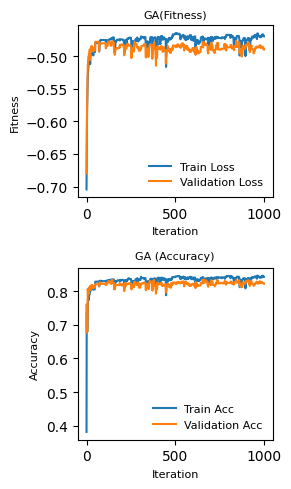

In [27]:
# plot the iterative learning curve (loss)
fig = plt.figure(figsize=(3,5))
ax1=fig.add_subplot(2,1,1)



plt.plot(-np.array(net.history[:, 'train_loss']), label='Train Loss')
plt.plot(-np.array(net.history[:, 'valid_loss']), label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fitness")
ax1.set_title("GA(Fitness)")
# plt.grid(visible=True)
plt.legend(frameon=False)

ax2=fig.add_subplot(2,1,2)
plt.plot(net.history[:, 'train_acc'], label='Train Acc')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("GA (Accuracy)")
# plt.grid(visible=True)
plt.legend(frameon=False)


plt.rcParams.update({
    'font.size': 10,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

plt.tight_layout() 
plt.savefig('figs/fitness_GA_NN.pdf')
plt.show()

## Using sklearn learning curve with RO

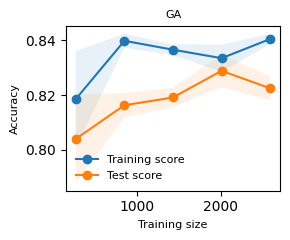

In [28]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)


fig = plt.figure(figsize=(3,2.5))

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     )
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,)
plt.plot(train_sizes, train_scores_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Test score",marker='o')
plt.title("GA")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
# plt.grid(visible=True)
plt.legend(frameon=False)


plt.rcParams.update({
    'font.size': 10,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

plt.tight_layout() 
plt.savefig('figs/accuracy_GA_NN.pdf')
plt.show()

## Using sklearn grid search with RO

In [ ]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [12],
    'module__output_dim': [2],
    'max_epochs': [5],
    'module__population_size': [300],
    'module__to_mate': [150],
}

grid_search_params = {
    'module__to_mutate': [30, 60],
    **default_params,
}

gs = GridSearchCV(net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_epochs=5, module__input_dim=12, module__output_dim=2, module__population_size=300, module__to_mate=150, module__to_mutate=30; total time=  14.1s
[CV] END max_epochs=5, module__input_dim=12, module__output_dim=2, module__population_size=300, module__to_mate=150, module__to_mutate=30; total time=  16.1s
[CV] END max_epochs=5, module__input_dim=12, module__output_dim=2, module__population_size=300, module__to_mate=150, module__to_mutate=30; total time=  17.3s
[CV] END max_epochs=5, module__input_dim=12, module__output_dim=2, module__population_size=300, module__to_mate=150, module__to_mutate=60; total time=  17.3s
[CV] END max_epochs=5, module__input_dim=12, module__output_dim=2, module__population_size=300, module__to_mate=150, module__to_mutate=60; total time=  17.2s
[CV] END max_epochs=5, module__input_dim=12, module__output_dim=2, module__population_size=300, module__to_mate=150, module__to_mutate=60; total time= 